<hr style = "background-color: darkcyan; width:80%; text-align:center; height:5px">
    <h1 style = "color : darkcyan; text-align:center;">
         Procesamiento de datos y entrenamiento del modelo
    <h1/>
<hr style = "background-color: darkcyan; width:80%; text-align:center; height:5px">

<h1 style = "color : darkcyan; text-align:left;">
   1) Configuraciones y definiciones iniciales
<h1/>

#### Importamos modulos y librerias necesarias.

In [1]:
import pathlib
import pyprind
import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict , List
from tensorflow.python.client import device_lib
from termcolor import cprint
%load_ext tensorboard

#### Obtenemos informacion sobre las GPU's del equipo, ademas establecemos aumento de la vram segun corresponda.

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')

tf.config.experimental.set_memory_growth(physical_devices[0], True)

#### Verificamos la aceleracion por GPU de tensorflow y seleccionamos la GPU dedicada.

In [3]:
if tf.test.gpu_device_name():
    
    gpu = device_lib.list_local_devices()[1]
    
    cprint('Default GPU Device: {}'.format(gpu.physical_device_desc.split(",")[1]),color = "green")
    
else:
    
    cprint("Please install GPU version of TF",color = "red")

Default GPU Device:  name: NVIDIA GeForce RTX 3060


#### Desplegamos informacion del dataset leyendo el archivo README.txt

In [4]:
with open(file = r"D:\Dataset\README.txt",mode = "r")  as file:
    
    cprint("""
--------------------
DATASET INFORMATION:
--------------------
    """,color = "green")
    
    cprint(file.read(),color = "green")


--------------------
DATASET INFORMATION:
--------------------
    
### Description ###
A team of Researchers from Quatar University, Doha and Dhaka University along with their connections from Pakistan, Malaysia, in collaboration with doctors, have created the primary dataset with 4 classes(COVID-19, Lung-Opacity, Normal and Viral Pneumonia). The primary dataset has been collected from the Kaggle (COVID-19 Radiography Database [1]). We have added some more contents of Pneumonia and COVID-19 with it from various online resources [2, 3, 4, 5]. Our research work has added one more class with Tuberculosis with the 4 class dataset. We have removed the lateral view Chest X rays and added only the frontal view to the dataset.  The final dataset created using [1, 2 ,3 ,4, 5, 6, 7] has formed a 5 class chest X ray dataset with infectious respiratory diseases. 

### Class Distribution ###
This dataset is a combination of COVID-19, Lung-Opacity, Normal, Viral Pneumonia and Tuberculosis classes.

#### Creamos una lista que contenga todas las clases definidas en el README.

In [5]:
classes : List = ["COVID-19","Lung-Opacity","Normal","Viral Pneumonia","Tuberculosis"]

#### Creamos diccionario en el cual se almacenan las rutas de los conjuntos de entrenamiento, validacion y prueba.

In [6]:
data_paths : Dict  = {"training":r"D:\tesis_dataset\Dataset5_raw_train.npz",
                      "validation": r"D:\tesis_dataset\Dataset5_raw_val.npz",
                      "testing":r"D:\tesis_dataset\Dataset5_raw_test.npz"}

#### Leemos la data con np.load() de manera que podemos leer correctamente los archivos .npz, en donde estan contenidos diccionarios de python con la data.

In [7]:
train  = np.load(data_paths["training"])

val  = np.load(data_paths["validation"])

test = np.load(data_paths["testing"])

#### Se crea una funcion que obtengos la data correspondiente a las imagenes desde los diccionarios y las guardamos con el nombre de la clase a la que pertenece, de manera que creamos un dataset de imagenes y no de diccionarios.

In [8]:
def to_images(subset,subset_name,labels) -> None:
    
    base_path : str = "D:\Dataset"
    
    bar = pyprind.ProgBar(len(subset["image_label"]))
    
    for arr, label, name in zip(subset["image"],subset["image_label"],subset["image_name"]):

        img = PIL.Image.fromarray((arr).astype(np.uint8))

        img.save(f"{base_path}/{subset_name}/{labels[int(label)]}/{name[0]}")
        
        bar.update()

#### Se genera el dataset con el subscript definido en la funcion to_images y finalmente, de forma manual, se eliminan  imagenes que presentan una distribucion distinta de la normal, para evitar el underfitting.

In [9]:
to_images(train,"training",classes)
to_images(val,"validation",classes)
to_images(test,"test",classes)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:20:02
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:04:36
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:04:03


<h1 style = "color : darkcyan; text-align:left;">
   2) Preprocesamiento y analisis de los datos
<h1/>

####  Se define una funcion que crea un dataframe por  cada conjunto de datos, y asi poder visualizar la distribucion de las clases.

In [9]:
def to_dataframe(k_set) -> pd.DataFrame :
    
    idx : List = [i for i in range(k_set["image_name"].shape[0])]

    data : pd.DataFrame = pd.DataFrame(columns = ["name"],
                                       data = k_set["image_name"],
                                       index = pd.Index(idx))

    data["label"] = k_set["image_label"]
    
    data["classes"] = data["label"].apply(lambda x: classes[int(x)])
    
    
    return data

#### Generamos los dataframe y  aplicamos un shuffle para que se reordene la data de forma aleatoria.

In [10]:
from sklearn.utils import shuffle

train_df = shuffle(to_dataframe(train))

valid_df = shuffle(to_dataframe(val))

test_df = shuffle(to_dataframe(test))

print(f"""

Train shape: {train_df.shape}

valid shape: {valid_df.shape}

Test shape: {test_df.shape}
""")
train_df.head()



Train shape: (19610, 3)

valid shape: (6534, 3)

Test shape: (6540, 3)



,name,label,classes
6615,Normal-3934.png,2.0,Normal
18371,CXR847_IM-2369-1001.png,4.0,Tuberculosis
4697,Lung_Opacity-2832.png,1.0,Lung-Opacity
19170,CXR954_IM-2448-12001.png,4.0,Tuberculosis
18091,CHNCXR_0556_1.png,4.0,Tuberculosis


 #### Generamos diccionarios que contengan la distribucion de clase para cada conjunto de datos.

In [11]:
train_class_dist : Dict = dict(train_df["label"].value_counts())

valid_class_dist : Dict = dict(valid_df["label"].value_counts())

test_class_dist : Dict = dict(test_df["label"].value_counts())

#### Graficamos la distribucion de clase para cada conjunto de datos.

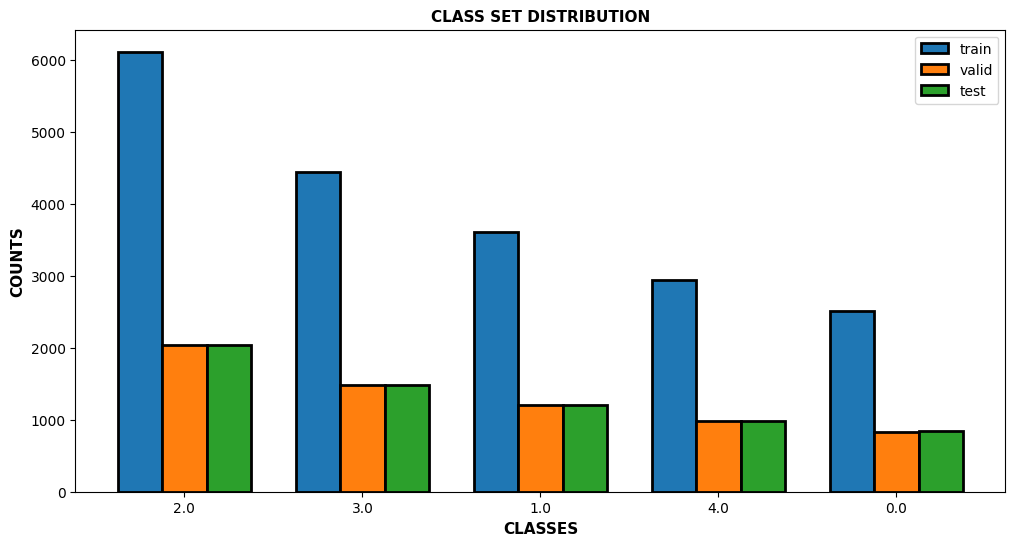

In [13]:
plt.rcParams["figure.figsize"] = (12,6)

barwidth = 0.25
 
data : List = [train_class_dist.values(),
                valid_class_dist.values(),
                test_class_dist.values()]

fbar : List = np.arange(len(train_class_dist.values()))

sbar : List = [x + barwidth for x in fbar]

lbar : List = [x + barwidth for x in sbar]
    
bars : List = [fbar,sbar,lbar]

labels : List = ["train","valid","test"]

for bar, values, label in zip(bars,data,labels):

    plt.bar(bar, values,
            width = barwidth,
            edgecolor ='black',
            linewidth = 2,
            label = label)

plt.title('CLASS SET DISTRIBUTION', fontweight ='bold', fontsize = 11)

plt.xlabel('CLASSES', fontweight ='bold', fontsize = 11)

plt.ylabel('COUNTS', fontweight ='bold', fontsize = 11)

plt.xticks([r + barwidth for r in range(len(data[0]))],train_class_dist.keys())
 
plt.legend()
plt.show()

#### Creamos un generador  para cada set de datos, en donde para el set de train, aplicamos unas tranformaciones a las imagenes para tener mas data de entrenamiento y mayor distribucion (data augmentation). ademas se definen las diemnsiones de las imagenes y el batch size.

In [15]:
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_WIDTH : int = 224
    
IMG_HEIGHT : int = 224 

BATCH_SIZE : int = 16

train_gen = ImageDataGenerator(rotation_range = 8.5,
                               width_shift_range = 0.1,
                               height_shift_range = 0.3,
                               zoom_range = 0.1,
                               horizontal_flip = True)

validation_gen = ImageDataGenerator()

test_gen = ImageDataGenerator()

#### Leemos el dataset de imagenes previamente creado, definimos el tipo de clasificacion y aplicamos un shuffle a las imagenes.

In [16]:
paths = [r"D:\Dataset\training",
         r"D:\Dataset\validation",
         r"D:\Dataset\test"]

train_set = train_gen.flow_from_directory(directory = paths[0],
                                         target_size = (IMG_WIDTH ,IMG_HEIGHT),
                                         batch_size = BATCH_SIZE,
                                         class_mode = 'categorical',
                                         shuffle = True)

validation_set = validation_gen.flow_from_directory(directory = paths[1],
                                                   target_size = (IMG_WIDTH ,IMG_HEIGHT),
                                                   batch_size = BATCH_SIZE,
                                                   class_mode = 'categorical',
                                                   shuffle = True)



test_set = test_gen.flow_from_directory(directory = paths[2],
                                        target_size = (IMG_WIDTH ,IMG_HEIGHT),
                                        batch_size = BATCH_SIZE,
                                        class_mode = 'categorical')

Found 19461 images belonging to 5 classes.
Found 6474 images belonging to 5 classes.
Found 6472 images belonging to 5 classes.


#### Visualizamos las dimensiones del lote.

In [17]:
image = next(train_set)[0][0:]
image.shape

(16, 224, 224, 3)

#### Visualizamos datos tomados aleatoriamente del primer lote.

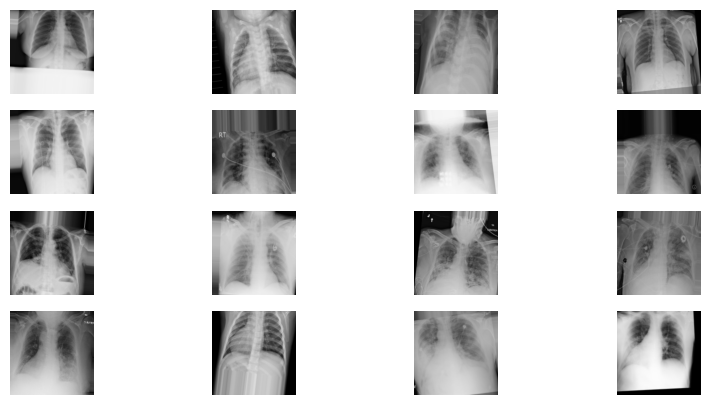

In [18]:
from random import randint

rows : int = 4
cols : int = 4

fig, ax = plt.subplots(nrows = rows, ncols = cols,figsize = (10,5))

for i in range(rows):
    
    for j in range(cols):

        image = next(train_set)[0][randint(0,BATCH_SIZE - 1)]

        ax[i,j].imshow(image / 255)
        ax[i,j].axis("off")

<h1 style = "color : darkcyan; text-align:left;">
   3) Arquitectura, pipeline y entrenamiento
<h1/>

#### Importamos el modelo VGG16, modelo el cual fue entrenado con el dataset imagenet, en donde para nuestro modelo, se creara una arquitectura hibrida, que comprende una etapa de transfer learning (pesos del VGG16) y una arquitecura de salida concatenada a las primeras capas de bajo nivel del  VGG16 de manera que se consiga hacer un ajuste fino del modelo. Esta arquitectura sera definida de forma arbitraria y se creara un pool de modelos para analizar su performance de manera independiente y tomar uno de estos como modelo final para nuestro proyecto.
#### Se observa que no considera las ultimas capas del modelo, para las demas conservamos los pesos del imagenet, definimos el shape de entrada (dimensiones de las imagenes), las clases de nuestro dataset y finalmente se imprime un summary del modelo VGG16.

#### Se crea una funcion que servira para neustro pool de modelos en donde podemos modificar el arch split (corte de la arquitectura) del modelo VGG16, definiendo asi, que partes del modelo seran entrenables y cuales no.

In [124]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2

def vgg_16_cut(trainig_layers : int):
    
    vgg_model = VGG16(include_top = False,
                      weights = "imagenet",
                      input_shape = (224,224,3),
                      classes = len(classes))
    
    model_deep = len(vgg_model.layers)
    
    model_split = model_deep - trainig_layers

    for layer in vgg_model.layers[:model_split]:
        
        layer.trainable = False

    for i, layer in enumerate(vgg_model.layers):
        
        print(i, layer.name, layer.trainable)

    return vgg_model

    
def base_pipeline(vggmod, input_matrix):

    normalizer  = layers.Rescaling(1./255) (input_matrix)

    output = vggmod(normalizer)
    
    return output

def fine_tunning_arch(vgg_output, arch):
    
    output = vgg_output
        
    for layer in arch:
        
        output = layer(output)
        
    return output

#### Se crean 3 arquitecturas de salida para los distintos cortes del VGG16

In [125]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D

arch1 : List = [Flatten(),
                
               Dense(units = 256,
                     activation = "relu"),
                
               Dropout(0.5),
                
               Dense(units = 128,
                     activation = "relu"),
                
               BatchNormalization(),
                
               Dropout(0.4),
               
               Dense(units = len(classes),
                     activation = "softmax",
                     kernel_regularizer = l2(l2 = 0.001))]
    
arch2 : List = [Flatten(),
                
                Dropout(0.3),
                
                Conv2D(filters = 32,
                       kernel_size = (5,5),
                       strides = (1, 1),
                       padding = 'same',
                       activation = "relu"),
                
                BatchNormalization(),
                
                MaxPool2D(pool_size = (2, 2),
                          strides = (1,1),
                          padding = 'valid'),
                
                Dense(units = 128,
                      activation = lambda x: K.sin(x) * x ,
                      kernel_regularizer = l2(l2 = 0.01)),
                
                Dropout(0.3),
               
                Dense(units = len(classes),
                      activation = "softmax",
                      kernel_regularizer = l2(l2 = 0.001))]
    
    
arch3 : List = [Flatten(),
                
                BatchNormalization(),
                
                Dense(units = 128,
                      activation = "selu"),
                
                Dropout(0.3),
               
                Dense(units = len(classes),
                      activation = "softmax",
                      kernel_regularizer = l2(l2 = 0.001))]

#### Se crea una funcion que genere los pipelines de los modelos en funcion de las arquitecturas definidas y los splits del VGG16

In [29]:
def model_pipeline(t_layer, arch, name):

    inputs = layers.Input(shape = (224,224, 3))

    vgg = vgg_16_cut(trainig_layers = t_layer)

    mod = base_pipeline(vgg, inputs)

    outputs = fine_tunning_arch(mod, arch = arch)

    model = tf.keras.Model(inputs = inputs,
                           outputs = outputs,
                           name = name)
    return model

#### Creamos 3 modelos a entrenar

In [132]:
model1 = model_pipeline(t_layer = 5,
                        arch = arch1,
                        name = "model_arch_1")

0 input_26 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [133]:
model2 = model_pipeline(t_layer = 2,
                        arch = arch1,
                        name = "model_arch_2")

0 input_28 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 True
18 block5_pool True


In [134]:
model3 = model_pipeline(t_layer = 7,
                        arch = arch1,
                        name = "model_arch_3")

0 input_30 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


#### Creamos una funcion que entrene los modelos de manera iterativa insertando optimizador, metricas y callbacks

In [135]:
from tensorflow.keras.losses import CategoricalCrossentropy 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy, Recall
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

def train_pool(archs, epochs):
    
    history_log : List = list()
        
    models : List = list()
        
    adam_optimizer = Adam(learning_rate = 0.001)
    
    lr_reduction = ReduceLROnPlateau(monitor = 'val_categorical_accuracy',
                                     patience = 2,
                                     verbose = 1,
                                     factor = 0.6,
                                     min_lr = 0.000001)
    
    
    early_stop = EarlyStopping(monitor="val_loss",
                               patience = 7,
                               verbose = 1,
                               mode="auto",
                               restore_best_weights = True)

    for i, model_arch in enumerate(archs):
    
        tensorboard_callback = TensorBoard(log_dir = f"logs/model_arch_{i}",
                                           histogram_freq = 1)

        model_arch.compile(loss = CategoricalCrossentropy(),
                           optimizer = adam_optimizer, 
                           metrics = [CategoricalAccuracy(),
                                      Recall()])
        
        history = model_arch.fit(x = train_set,
                                 validation_data = validation_set,
                                 epochs = epochs,
                                 callbacks = [lr_reduction,
                                              early_stop,
                                              tensorboard_callback])
        
        history_log.append(history)
        
        models.append(model_arch)
        
    return history_log,  models

#### Entrenamos el pool de modelos estableciendo 25 epocas por modelo

In [36]:
history_logs, models = train_pool(archs = [model1,
                                           model2,
                                           model3],
                                  epochs = 25)

Epoch 1/25
1217/1217 [==============================] - 745s 606ms/step - loss: 1.5228 - categorical_accuracy: 0.3970 - recall: 0.2327 - val_loss: 1.2660 - val_categorical_accuracy: 0.4774 - val_recall: 0.3244
Epoch 2/25
1217/1217 [==============================] - 236s 194ms/step - loss: 1.1028 - categorical_accuracy: 0.5814 - recall: 0.4231 - val_loss: 1.1918 - val_categorical_accuracy: 0.5850 - val_recall: 0.5201
Epoch 3/25
1217/1217 [==============================] - 158s 130ms/step - loss: 0.8875 - categorical_accuracy: 0.6688 - recall: 0.5455 - val_loss: 0.6330 - val_categorical_accuracy: 0.7821 - val_recall: 0.6671
Epoch 4/25
1217/1217 [==============================] - 158s 130ms/step - loss: 0.7447 - categorical_accuracy: 0.7336 - recall: 0.6516 - val_loss: 0.6431 - val_categorical_accuracy: 0.7686 - val_recall: 0.7022
Epoch 5/25
1217/1217 [==============================] - 158s 130ms/step - loss: 0.6530 - categorical_accuracy: 0.7762 - recall: 0.7093 - val_loss: 0.8835 - val_

1217/1217 [==============================] - 158s 130ms/step - loss: 0.5384 - categorical_accuracy: 0.8164 - recall_1: 0.7712 - val_loss: 0.4236 - val_categorical_accuracy: 0.8412 - val_recall_1: 0.8204
Epoch 13/25
1217/1217 [==============================] - 177s 146ms/step - loss: 0.5300 - categorical_accuracy: 0.8186 - recall_1: 0.7784 - val_loss: 0.5851 - val_categorical_accuracy: 0.7766 - val_recall_1: 0.7529
Epoch 14/25
1217/1217 [==============================] - 190s 157ms/step - loss: 0.5187 - categorical_accuracy: 0.8229 - recall_1: 0.7827 - val_loss: 0.5493 - val_categorical_accuracy: 0.7915 - val_recall_1: 0.7668

Epoch 00014: ReduceLROnPlateau reducing learning rate to 2.799360081553459e-05.
Epoch 15/25
1217/1217 [==============================] - 158s 130ms/step - loss: 0.4987 - categorical_accuracy: 0.8300 - recall_1: 0.7898 - val_loss: 0.4409 - val_categorical_accuracy: 0.8431 - val_recall_1: 0.8126
Epoch 16/25
1217/1217 [==============================] - 158s 130ms/ste

#### Visualizamos con tensorboard el entrenamiento de los modelos y sus metricas

In [37]:
tensorboard --logdir=logs/ --host localhost --port 8065

#### Creamos funcion que toma el mayor accuracy generado por cada modelo y poder seleccionar el que tuvo mejor rendimiento

In [89]:
def get_best_model(logs,models):
    
    perf_mod = dict()
    
    for k, log, model in zip(range(len(logs)),logs, models):
        
        values = log.history["val_categorical_accuracy"]
        
        b_acc = np.argmax(values)
        
        perf_mod[model] = f"{round(values[b_acc] * 100 ,3)}%"
        
    return perf_mod

In [104]:
models_perf = get_best_model(history_logs, models)

models_perf

{<keras.engine.functional.Functional at 0x2a668512070>: '89.635%',
 <keras.engine.functional.Functional at 0x2a6685ced60>: '87.612%',
 <keras.engine.functional.Functional at 0x2a6686377c0>: '83.411%'}

#### Seleccionamos el model_arch_1 como arcquitectura final

In [105]:
best_model = models[0]

best_model.summary()

Model: "model_arch_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

#### Guardamos el modelo

In [119]:
best_model.save('Models\model')

INFO:tensorflow:Assets written to: Models\model\assets


<h1 style = "color : darkcyan; text-align:left;">
   4) Analisis de rednimiento del modelo
<h1/>

#### Creamos una funcion que tome las imagenes test y las ingrasamos al modelo para que haga inferencia y poder realizar un reporte de clasificacion y  matriz de confusion, ademas de retornar una lista con las clases correspondientes respectivamente

In [113]:
from tensorflow.keras.preprocessing import image

def pred_vs_target(classes, model, set_path):
    
    y_true = list()
    
    preds = list()
    
    eval_set = pathlib.Path(set_path)

    images = list(eval_set.glob('*/*'))
    
    pbar = pyprind.ProgBar(len(images))
    
    for img in images:

        y_true.append(str(img).split("\\")[3])
        
        img_load = image.load_img(img,target_size=(IMG_WIDTH, IMG_HEIGHT))

        img_array = image.img_to_array(img_load)

        img_batch = np.expand_dims(img_array, axis=0)

        y_hat = model.predict(img_batch)

        preds.append(classes[np.argmax(y_hat)])
        
        pbar.update()
        
    return y_true, preds

In [114]:
y_true, y_hat = pred_vs_target(classes, best_model, paths[2])

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:08:13


#### Generamos reporte de clasificacion

In [115]:
from sklearn.metrics import classification_report

print(classification_report(y_hat,y_true,target_names = classes))

                 precision    recall  f1-score   support

       COVID-19       0.78      0.97      0.87       676
   Lung-Opacity       0.80      0.93      0.86      1039
         Normal       0.76      0.93      0.84      1670
Viral Pneumonia       0.97      0.86      0.91      1664
   Tuberculosis       0.95      0.61      0.74      1423

       accuracy                           0.85      6472
      macro avg       0.85      0.86      0.84      6472
   weighted avg       0.87      0.85      0.84      6472



#### Generamos matriz de confusion

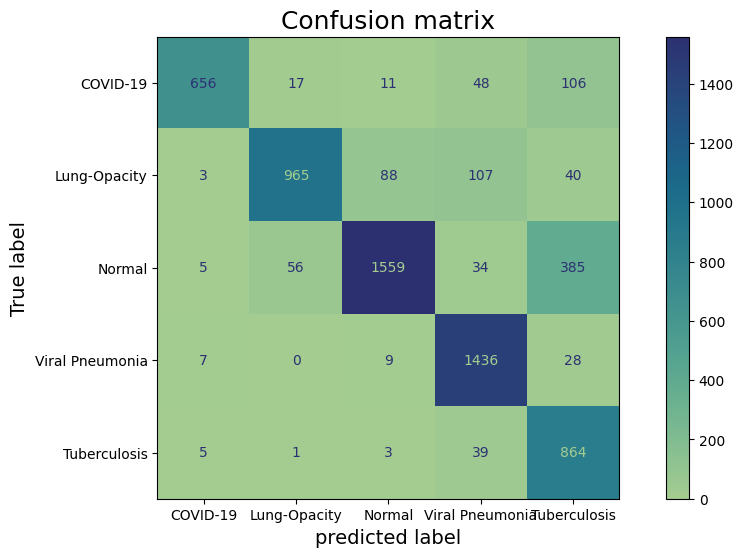

In [120]:
from sklearn.metrics import ConfusionMatrixDisplay , confusion_matrix

confm = confusion_matrix(y_true,y_hat)

display_conf = ConfusionMatrixDisplay(confusion_matrix = confm,display_labels=classes)

display_conf.plot(cmap="crest")
plt.title("Confusion matrix",fontsize = 18)
plt.xlabel("predicted label",fontsize = 14)
plt.ylabel("True label",fontsize = 14)
plt.show()